In [1]:
from __future__ import print_function
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.contrib.layers import fully_connected, batch_norm

from utils import *

Run the following code to apply the slurm restriction

In [2]:
import os
NUM_THREADS = int(os.environ['OMP_NUM_THREADS'])
sess = tf.Session(config=tf.ConfigProto(
    intra_op_parallelism_threads=NUM_THREADS,
    inter_op_parallelism_threads=NUM_THREADS))

Convenient functions to show the running time

In [3]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

All the hyperparameters

In [4]:
batch_size = 64
number_inputs = 66
number_outputs = 8
seq_len = 300 # max 700
learning_rate = 0.001
val_interval = batch_size * 5
print_interval = batch_size * 10
samples_to_process = 1e4
num_layers = 3

Load all the data

In [5]:
# Get all the data
trainList_addr = './data/trainList'
validList_addr = './data/validList'
testList_addr = './data/testList'

start = time.time()
train_list, train_len_list = read_list(trainList_addr)
valid_list, valid_len_list = read_list(validList_addr)
test_list, test_len_list = read_list(testList_addr)

train_generator = generate_batch(train_list, train_len_list,
                                 max_seq_length=seq_len,
                                 batch_size=batch_size)

X_train, t_train, len_train, mask_train = train_generator.next()
# X_train, t_train, len_train = read_data(train_list, train_len_list,
#                                         max_seq_length=seq_len)
X_valid, t_valid, len_valid, mask_valid = read_data(valid_list, valid_len_list,
                                        max_seq_length=max(valid_len_list))
X_test, t_test, len_test, mask_test = read_data(test_list, test_len_list,
                                     max_seq_length=max(test_len_list))

timeSpent = time.time() - start
print("Time spent loading data: {}".format(asMinutes(timeSpent)))
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test:", X_test.shape)

Time spent loading data: 0m 34s
X_train: (64, 300, 66)
X_valid: (1267, 683, 66)
X_test: (1267, 687, 66)


In [6]:
print(t_test.shape)
print(mask_test.shape)

(1267, 687)
(1267, 687)


In [7]:
reset_default_graph()

X_input = tf.placeholder(tf.float32, shape=[None, None, number_inputs], name='X_input')
X_length = tf.placeholder(tf.int32, shape=[None,], name='X_length')
t_input = tf.placeholder(tf.int32, shape=[None, None], name='t_input')
X_mask = tf.placeholder(tf.int32, shape=[None, None], name='X_mask')

num_units_encoder = 100
num_units_l1 = 100

cell_fw = tf.nn.rnn_cell.GRUCell(num_units_encoder)
cell_bw = tf.nn.rnn_cell.GRUCell(num_units_encoder)
#enc_cell = tf.nn.rnn_cell.OutputProjectionWrapper(enc_cell, number_outputs)
enc_outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw=cell_fw, cell_bw=cell_bw, inputs=X_input,
                                                 sequence_length=X_length, dtype=tf.float32)

enc_outputs = tf.concat(enc_outputs, 2)
outputs = tf.reshape(enc_outputs, [-1, num_units_encoder*2])
l1 = fully_connected(outputs, num_units_l1, normalizer_fn=batch_norm)
l_out = fully_connected(l1, number_outputs, activation_fn=None)

batch_size_shp = tf.shape(enc_outputs)[0]
seq_len_shp = tf.shape(enc_outputs)[1]
l_out_reshape = tf.reshape(l_out, [batch_size_shp, seq_len_shp, number_outputs])

y = l_out_reshape

The following code use softmax_cross_entropy_with_logits to resolve the NaN problem.

**This piece is working!!!**

The following code uses sparse_softmax_cross_entropy_with_logits but with number_outputs = 9. 

In [8]:
# Derive the mask to filter out zero-padding when calculating loss and accuracy
X_mask = tf.to_float(X_mask)
mask_sum = tf.reduce_sum(X_mask)
# Calculate loss
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=t_input, logits=y)
# print(cross_entropy.dtype)
cross_entropy *= X_mask
# tf.reduce_mean cannot be used because it will count zero-padding for weights.
loss = tf.reduce_sum(cross_entropy) / mask_sum
# Calculate accuracy. Need to exclude the padded zeros.

predictions = tf.to_int32(tf.argmax(y, 2))
correct = tf.to_float(tf.equal(predictions, t_input))
correct_masked = correct * X_mask
accuracy = tf.reduce_sum(correct_masked) / mask_sum

# use global step to keep track of our iterations
global_step = tf.Variable(0, name='global_step', trainable=False)
# pick optimizer, try momentum or adadelta
optimizer = tf.train.AdamOptimizer(learning_rate)
# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [9]:
for i in tf.trainable_variables():
    print(i)

<tf.Variable 'bidirectional_rnn/fw/gru_cell/gates/kernel:0' shape=(166, 200) dtype=float32_ref>
<tf.Variable 'bidirectional_rnn/fw/gru_cell/gates/bias:0' shape=(200,) dtype=float32_ref>
<tf.Variable 'bidirectional_rnn/fw/gru_cell/candidate/kernel:0' shape=(166, 100) dtype=float32_ref>
<tf.Variable 'bidirectional_rnn/fw/gru_cell/candidate/bias:0' shape=(100,) dtype=float32_ref>
<tf.Variable 'bidirectional_rnn/bw/gru_cell/gates/kernel:0' shape=(166, 200) dtype=float32_ref>
<tf.Variable 'bidirectional_rnn/bw/gru_cell/gates/bias:0' shape=(200,) dtype=float32_ref>
<tf.Variable 'bidirectional_rnn/bw/gru_cell/candidate/kernel:0' shape=(166, 100) dtype=float32_ref>
<tf.Variable 'bidirectional_rnn/bw/gru_cell/candidate/bias:0' shape=(100,) dtype=float32_ref>
<tf.Variable 'fully_connected/weights:0' shape=(200, 100) dtype=float32_ref>
<tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>
<tf.Variable 'fully_connected_1/weights:0' shape=(100, 8) dtype=float32_ref>
<tf.Va

In [10]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())

print("=" * 10 + "validating the model"+ "=" * 10)
# test validation part
# sess.run(tf.global_variables_initializer())
feed_dict = {X_input: X_valid, X_length: len_valid,
             t_input: t_valid, X_mask: mask_valid}
fetches = [y, t_input, predictions, cross_entropy, enc_outputs, outputs, l1]
res = tuple(sess.run(fetches=fetches, feed_dict=feed_dict))
print("y:", res[0].shape)
print("t_input", res[1].shape)
print("predictions", res[2].shape)
print("Cross Entropy", res[3].shape)
print("enc_outputs", res[4].shape)
print("outputs", res[5].shape)
print("l1", res[6].shape)
print(res[3][0, 0:200])
# print(res[5][0, 0:200])
# print(res[6][0, 0:200])
print("=" * 10 + "Model validation finished"+ "=" * 10)

==========validating the model==========
y: (1267, 683, 8)
t_input (1267, 683)
predictions (1267, 683)
Cross Entropy (1267, 683)
enc_outputs (1267, 683, 200)
outputs (865361, 200)
l1 (865361, 100)
[ 2.47261143  1.48216796  1.06977654  2.35565782  5.76333094  1.76045787
  1.77337122  1.86402535  1.54179764  1.90952754  1.74767065  4.40693998
  0.86702359  0.74647647  0.87528944  0.68557179  3.45605254  0.83203238
  2.76879096  2.89171028  3.07740879  5.55807543  0.80262613  1.04916286
  2.78229284  3.61127257  2.74790549  3.44143438  2.68848419  0.35979575
  0.49571335  4.42177963  4.99732256  4.92472649  1.0457269   1.30828238
  2.56679773  1.56456006  1.21414387  1.23222113  2.30451775  1.73938501
  1.05501056  4.53986025  1.29793906  1.28188133  1.38825941  3.55397987
  3.52390027  3.68080139  3.6607728   3.23761415  3.35120058  1.03067994
  1.37938499  1.72503757  1.60187995  1.41777658  1.41768312  0.80911297
  4.13940144  3.05489969  3.12752771  2.23602986  2.31211066  1.88577735


In [11]:
samples_processed = 0
samples_val = []
costs, accs_val = [], []
saver1 = tf.train.Saver()

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./graphs', sess.graph)
while samples_processed < samples_to_process:
    # make fetches
    fetches_tr = [train_op, loss, accuracy]
    # set up feed_dict
    feed_dict_tr = {X_input: X_train, X_length: len_train,
                    t_input: t_train, X_mask: mask_train}
    # run the model
    res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
    _, batch_cost, batch_acc = res
    samples_processed += batch_size
    
    #validation data
    if samples_processed % val_interval == 0:
        fetches_val = [accuracy, y]
        feed_dict_val = {X_input: X_valid, X_length: len_valid,
                         t_input: t_valid, X_mask: mask_valid}
        res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
        
        costs += [batch_cost]
        acc_val, output_val = res
        samples_val += [samples_processed]
        accs_val += [acc_val]

        if samples_processed % print_interval == 0:
            print("samples_processed: %d, batch_cost: %.2f, validation_accs: %.4f" % \
                  (samples_processed, batch_cost, acc_val))

saver1.save(sess, './bi_gru_300_dp')
writer.close()

samples_processed: 640, batch_cost: 1.03, validation_accs: 0.6356
samples_processed: 1280, batch_cost: 0.89, validation_accs: 0.6678
samples_processed: 1920, batch_cost: 0.84, validation_accs: 0.6799
samples_processed: 2560, batch_cost: 0.80, validation_accs: 0.6856
samples_processed: 3200, batch_cost: 0.77, validation_accs: 0.6889
samples_processed: 3840, batch_cost: 0.74, validation_accs: 0.6903
samples_processed: 4480, batch_cost: 0.72, validation_accs: 0.6904
samples_processed: 5120, batch_cost: 0.69, validation_accs: 0.6889
samples_processed: 5760, batch_cost: 0.66, validation_accs: 0.6874
samples_processed: 6400, batch_cost: 0.64, validation_accs: 0.6859
samples_processed: 7040, batch_cost: 0.61, validation_accs: 0.6836
samples_processed: 7680, batch_cost: 0.58, validation_accs: 0.6820
samples_processed: 8320, batch_cost: 0.55, validation_accs: 0.6800
samples_processed: 8960, batch_cost: 0.52, validation_accs: 0.6771
samples_processed: 9600, batch_cost: 0.49, validation_accs: 0.6

In [12]:
fetches_test = [accuracy, y, predictions]
feed_dict_test = {X_input: X_test, X_length: len_test,
                  t_input: t_test, X_mask: mask_test}
res = tuple(sess.run(fetches=fetches_test, feed_dict=feed_dict_test))

acc_test, output_test, predictions = res
print("Test Accuracy: {:.4f}".format(acc_test))
# print(predictions[0, :])
# print(t_test[0, :])

Test Accuracy: 0.6797


In [13]:
# with open("feat66_len300_dynamic_padding.txt","w") as f:
#     for (sample_val, acc_val, cost) in zip(samples_val, accs_val, costs):
#         f.write("{0},{1},{2}\n".format(sample_val, acc_val, cost))

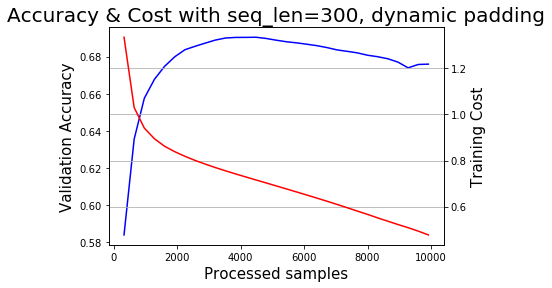

In [14]:
fig, ax1 = plt.subplots()
plt.plot(samples_val, accs_val, 'b-')
ax1.set_ylabel('Validation Accuracy', fontsize=15)
ax1.set_xlabel('Processed samples', fontsize=15)
plt.title('Accuracy & Cost with seq_len=300, dynamic padding', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(samples_val, costs, 'r-')
ax2.set_ylabel('Training Cost', fontsize=15)
plt.grid('on')
plt.savefig("out.png")
plt.show()

The following code is used to plot the stored information for old experiment and is not being used currently.

In [15]:
# samples_30, accs_30, costs_30 = [], [], []
# with open("feat66_len30.txt","r") as f:
#     for line in f:
#         line = line.split(',')
#         samples_30.append(line[0])
#         accs_30.append(line[1])
#         costs_30.append(line[2])

In [16]:
# fig, ax1 = plt.subplots()
# plt.plot(samples_30, accs_30, 'b-')
# ax1.set_ylabel('Validation Accuracy', fontsize=15)
# ax1.set_xlabel('Processed samples', fontsize=15)
# plt.title('Accuracy & Cost with seq_len=30', fontsize=20)
# ax2 = ax1.twinx()
# ax2.plot(samples_30, costs_30, 'r-')
# ax2.set_ylabel('Training Cost', fontsize=15)
# plt.grid('on')
# plt.savefig("out.png")
# plt.show()